# Newton's Method for Logistic Regression
Mihir Singh

## Implementing Newton Optimizer
The code for the Newton Optimizer can be found [here]().

In [61]:
# imports
from optimizer import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer
import torch
from matplotlib import pyplot as plt

## Abstract

## Experiments
With the Newton Optimizer implemented, we can perform some experiments to ensure that our implementation behaves correctly. We will use data from the previous logistic regression blog post.

In [62]:
# Generating some data
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.2)

Just to be sure, we will plot our data to ensure that it is linearly separable.

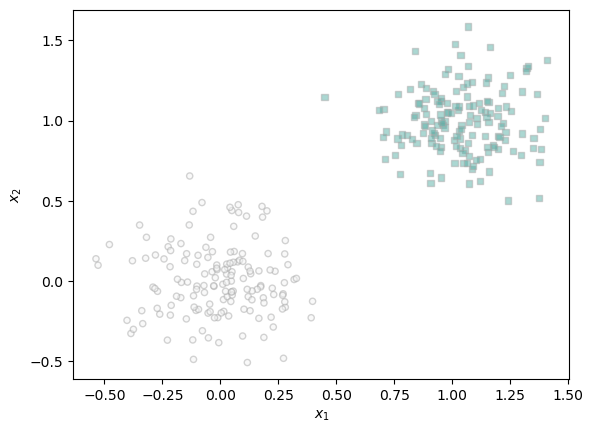

In [63]:
# function to plot data - from Professor Phil Chodrow
def plot_data(X, y, ax):
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# function to plot data - from Professor Phil Chodrow
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)
    
# function to determine accuracy of logistic regression models
def accuracy(model, X, y):
    return torch.mean((1.0*(model.predict(X) == y)))
    
# plotting loss
def loss_graph(loss_vec):
    plt.plot(loss_vec, marker='o', linestyle='-')
    plt.title('Loss Graph: Experiment 1')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    print("final loss: ", loss_vec[len(loss_vec)-1])

fig, ax = plt.subplots(1, 1)

X, y = classification_data()
plot_data(X, y, ax)

Indeed, the data seems, at least visually, to be linearly separable.

### Experiment 1
We will first make sure that when alpha is chosen appropriately, the Newton Optimizer converges to the optimal solution. We will first make our model then run it over a training loop before evaluating its performance.

tensor(1.)

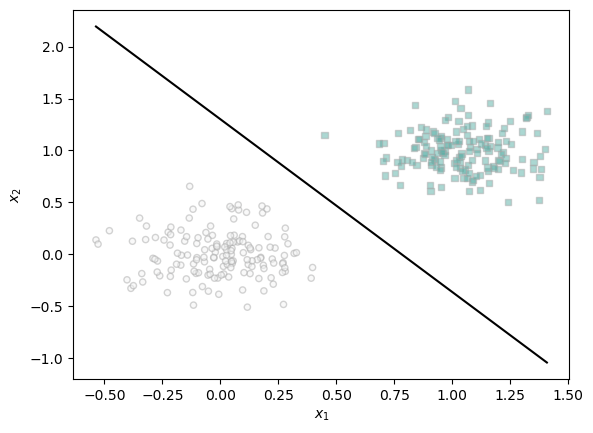

In [64]:
# creating our model
LR = LogisticRegression()
opt = NewtonOptimizer(LR)

# training loop
lossVec = []
for _ in range(7500):
    # add other stuff to e.g. keep track of the loss over time. 
    loss = opt.step(X, y, alpha = 0.25)
    lossVec.append(loss)
    
# plot decision classification
fix, ax = plt.subplots(1, 1)
plot_data(X, y, ax)
draw_line(LR.w, X[:,0].min(), X[:,0].max(), ax, color = "black")

# determine accuracy
accuracy(LR, X, y)

We see that our model does indeed converge to the optimal solution, with an accuracy of 100%.

We can also look at a loss graph to see how the model comes to a decision.

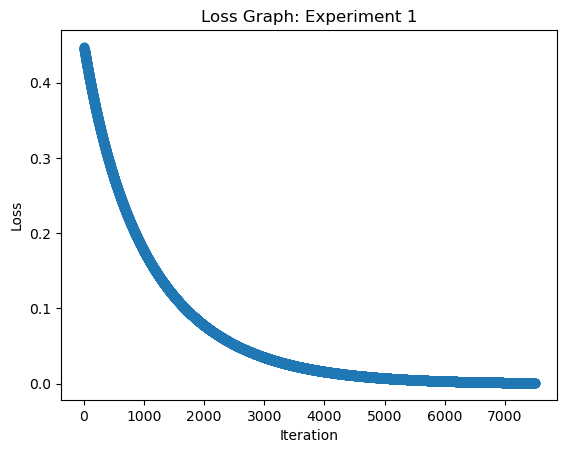

final loss:  tensor(0.0011)


In [65]:
loss_graph(lossVec)

We see that our loss converges to essentially 0 over the course of 7500 iterations with an alpha of 0.25. 

### Experiment 2
We will now see if Newton's method can converge much faster than standard gradient descent in terms of the empirical risk. We will try to see this behavior by making the alpha for the Newton Optimizer much larger.

In [66]:
# creating our model
LRnewt = LogisticRegression()
LRgrad = LogisticRegression()
newtonOpt = NewtonOptimizer(LRnewt)
gradOpt = GradientDescentOptimizer(LRgrad)

gradLossVec = []
for _ in range(7500):
    gradLoss = gradOpt.step(X, y, alpha = 0.01, beta = 0)
    gradLossVec.append(gradLoss)

newtLossVec = []
for _ in range(7500):
    newtLoss = newtonOpt.step(X, y, alpha = 0.4)
    newtLossVec.append(newtLoss)
    

After training the models, we can plot their losses.

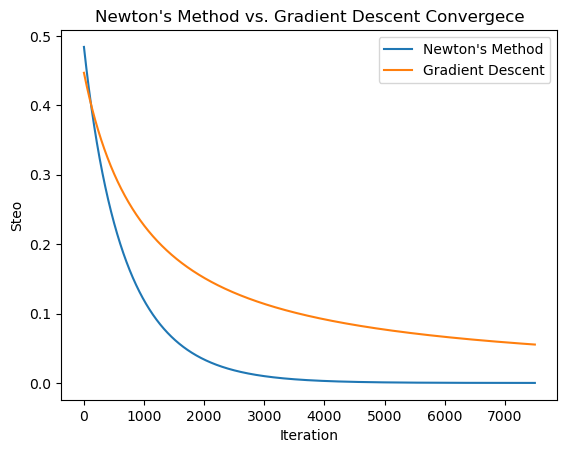

In [67]:
plt.plot(newtLossVec, label="Newton's Method")
plt.plot(gradLossVec, label="Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("Steo")
plt.title("Newton's Method vs. Gradient Descent Convergece")
plt.legend()
plt.show()

We see here that when the Newton Optimizer's alpha is much larger, and the standard gradient descent optimizer's alpha is very small, we have a scenario where the Newton Optimizer converges much faster than the standard gradient descent optimizer.

### Experiment 3
We will now look at a situation where the alpha provided to the Newton Optimizer is very large. When the alpha is too large, the Newton Optimizer will not converge to the optimal solution.

In [126]:
X, y = classification_data(n_points=300, noise = 0.5)

# create Newton Optimizer
LRnewt = LogisticRegression()
newtonOpt = NewtonOptimizer(LRnewt)

# run training loop
newtLossVec = []
for _ in range(100):
    newtLoss = newtonOpt.step(X, y, alpha = 610)
    newtLossVec.append(newtLoss)

After we have run our training loop, we can look at the loss graph.

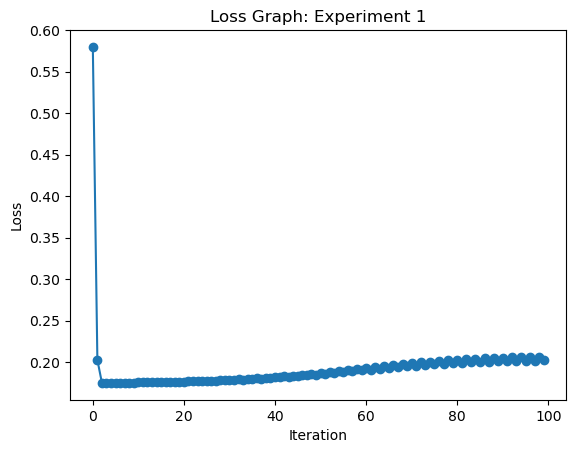

final loss:  tensor(0.2021)


In [127]:
loss_graph(newtLossVec)

We can see that when our alpha gets very large, we actually end up having our loss increase over time, thus with a high alpha, our model does not converge.

## Operation Counting
Assumptions:
1. Compute loss L costs C units.
2. Compute gradient G costs 2C units.
3. Compute Hessian H costs pc units.
4. Inverting pxp matrix is $k_1p^\gamma$ units
5. Multiplying by hessian = $k_2p^\gamma$

We also assume that Newton's method converges to an adequate solution in $t_\mathrm{nm}$ steps and standard gradient descent converges in $t_\mathrm{gd}$ steps.

Now to calculate the cost of Newton's method:

single step cost:
(2c + pc + $k_1p^\gamma$ + $
$k_2p^\gamma$)  

sum costs:
c + $t_\mathrm{nm}$ + (2c + pc + $k_1p^\gamma$ + $
$k_2p^\gamma$) 

Now to calculate the cost of standard method:

single step cost:
c

sum costs:
c + $t_\mathrm{gd}$ x 2c

With these costs calculated, we can compare the two methods. It seems that generally, Newton's method is more computationally expensive, but to compare we can create an inequality where the standard gradient descent cost is more than the newton method cost:

O(standard) > O(newton)

c + $t_\mathrm{gd}$ x 2c > c + $t_\mathrm{nm}$ + (2c + pc + $k_1p^\gamma$ + $
$k_2p^\gamma$) 

with some simplification, we get

$t_\mathrm{gd}$ > $t_\mathrm{nm}$ * (1 + p/2 + $k_1p^\gamma$/2c + $k_2p^\gamma$/2c)

So in order for Newton's method to be more computationally efficient, the above inequality must hold and $t_\mathrm{gd}$ must be larger than $t_\mathrm{nm}$ by a factor of (1 + p/2 + $k_1p^\gamma$/2c + $k_2p^\gamma$/2c) 

If p became very large, Newton's method would not every pay off since there are factors affecting the computational cost of the Newton Method that are dependent on, and grow polynomially with p. This means the cost of Newton's method grows significantly when p or $\gamma$ increases. With larger problems, standard gradient descent is probably a better optimization choice.

## Discussion
In this blog post
